# LSTM Statistic Predictor Using OPS(On-base Plus Slugging)

In this notebook, we will build and train a custom LSTM RNN that uses a 12 years of batting statistics data to predict the value of OPS.

## Statistics Use In Moneyball

According to Lewis (2003), Billy Beane (the inspiration of Moneyball) decided to base his drafting of position players/hitters on certain statistics. His main two statistics included `on-base percentage (OBP)` and `slugging percentage`. These two stats combined to form a new statistic called `on-base plus slugging (OPS)`.

The OPS formula below:

        OBP = (H + BB + HBP) / (AB + BB + HBP + SF)
        
        SLG = (1B)+(2∗2B)+(3∗3B)+(4∗HR) / AB
        

H = Hits - when the batter strikes the ball without error

BB = Walks - when a pitcher throws four pitches out of the strike zone, none of which are swing at by the batter

HBP = Hit by pitch - when a batter is struck by a pitched ball without swinging at it and is awarded first base

AB = At bat - when a batter reaches base via fielder's choice, hit, or error (not including catcher's interference)

SF = Sacrifice fly - when a batter hits a fly-ball to the outfield or foul territory that allows a runner to score

1B = Single - when batter hits the ball and reaches first base

2B = Double - when batter hits the ball and reaches second base

3B = Triple - when batter hits the ball and reaches third base

HR = Home run - when batter hits the ball and circles all four bases

In [1]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
import datetime
from pathlib import Path
import glob

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
import tensorflow as tf

%matplotlib inline

In [2]:
file_path = 'stats_df.csv'
stats_df = pd.read_csv(
    file_path,
    index_col=None,
    infer_datetime_format=True,
    parse_dates=True,
)
stats_df.head()

,Year,Player,Team,Pos,Age,G,AB,R,H,2B,3B,HR,RBI,SB,CS,BB,SO,SH,SF,HBP,AVG,OBP,SLG,OPS
0,2019,Whit Merrifield,KC,2B,32,162,681,105,206,41,10,16,74,20,10,45,126,0,4,5,0.302,0.348,0.463,0.811
1,2019,Marcus Semien,OAK,SS,30,162,657,123,187,43,7,33,92,10,8,87,102,0,1,2,0.285,0.369,0.522,0.891
2,2019,Rafael Devers,BOS,3B,24,156,647,129,201,54,4,32,115,8,8,48,119,1,2,4,0.311,0.361,0.555,0.916
3,2019,Jonathan Villar,BAL,2B,30,162,642,111,176,33,5,24,73,40,9,61,176,2,4,4,0.274,0.339,0.453,0.792
4,2019,Ozzie Albies,ATL,2B,24,160,640,102,189,43,8,24,86,15,4,54,112,0,4,4,0.295,0.352,0.500,0.852


In [3]:
# Drop player with 0 OPS
stats_df = stats_df[stats_df.OPS !=0].set_index('Player')

In [4]:
stats_df.head()

,Year,Team,Pos,Age,G,AB,R,H,2B,3B,HR,RBI,SB,CS,BB,SO,SH,SF,HBP,AVG,OBP,SLG,OPS
Player,,,,,,,,,,,,,,,,,,,,,,,
Whit Merrifield,2019,KC,2B,32,162,681,105,206,41,10,16,74,20,10,45,126,0,4,5,0.302,0.348,0.463,0.811
Marcus Semien,2019,OAK,SS,30,162,657,123,187,43,7,33,92,10,8,87,102,0,1,2,0.285,0.369,0.522,0.891
Rafael Devers,2019,BOS,3B,24,156,647,129,201,54,4,32,115,8,8,48,119,1,2,4,0.311,0.361,0.555,0.916
Jonathan Villar,2019,BAL,2B,30,162,642,111,176,33,5,24,73,40,9,61,176,2,4,4,0.274,0.339,0.453,0.792
Ozzie Albies,2019,ATL,2B,24,160,640,102,189,43,8,24,86,15,4,54,112,0,4,4,0.295,0.352,0.500,0.852


In [5]:
# Creating X & y variables
X = stats_df.iloc[:, 4:-2]
y = stats_df["OPS"].values

In [6]:
# Creating training, validation, and testing sets
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=78)

X_train.shape

(5914, 17)

In [7]:
# Scale the data
scaler = StandardScaler().fit(X)
X = scaler.transform(X)

y = y.reshape(-1, 1)
scaler_y = StandardScaler().fit(y)
y = scaler_y.transform(y)

In [8]:
y_train.shape

(5914,)

In [9]:
# Model set-up
number_input_features = 17
hidden_nodes_layer1 = 34
hidden_nodes_layer2 = 5

In [10]:
# Define the LSTM RNN model
model = Sequential()

# Layer 1
model.add(
    Dense(units=hidden_nodes_layer1, input_dim=number_input_features, activation="relu")
)

# Layer 2
model.add(Dense(units=hidden_nodes_layer2, activation="relu"))

# Output layer
model.add(Dense(1, activation="sigmoid"))

In [11]:
# Compile the model
model.compile(
    loss="binary_crossentropy",
    optimizer="adam",
    metrics=[
        "accuracy",
        tf.keras.metrics.TruePositives(name="tp"),
        tf.keras.metrics.TrueNegatives(name="tn"),
        tf.keras.metrics.FalsePositives(name="fp"),
        tf.keras.metrics.FalseNegatives(name="fn"),
        tf.keras.metrics.Precision(name="precision"),
        tf.keras.metrics.Recall(name="recall"),
        tf.keras.metrics.AUC(name="auc"),
    ],
)

In [12]:
# Training the model
batch_size = 1000
epochs = 50
training_history = model.fit(
    X_train,
    y_train,
    #validation_data=(X_val, y_val),
    epochs=epochs,
    batch_size=batch_size,
    verbose=1,
)

Epoch 1/50
6/6 [==============================] - 2s 8ms/step - loss: 8.2323 - accuracy: 0.0029 - tp: 5901.0000 - tn: 0.0000e+00 - fp: 0.0000e+00 - fn: 13.0000 - precision: 1.0000 - recall: 0.9978 - auc: 0.0000e+00
Epoch 2/50
6/6 [==============================] - 0s 6ms/step - loss: 2.7617 - accuracy: 0.0029 - tp: 4830.0000 - tn: 0.0000e+00 - fp: 0.0000e+00 - fn: 1084.0000 - precision: 1.0000 - recall: 0.8167 - auc: 0.0000e+00
Epoch 3/50
6/6 [==============================] - 0s 6ms/step - loss: 2.7604 - accuracy: 0.0025 - tp: 2656.0000 - tn: 0.0000e+00 - fp: 0.0000e+00 - fn: 3258.0000 - precision: 1.0000 - recall: 0.4491 - auc: 0.0000e+00
Epoch 4/50
6/6 [==============================] - 0s 6ms/step - loss: 1.9371 - accuracy: 0.0027 - tp: 5131.0000 - tn: 0.0000e+00 - fp: 0.0000e+00 - fn: 783.0000 - precision: 1.0000 - recall: 0.8676 - auc: 0.0000e+00
Epoch 5/50
6/6 [==============================] - 0s 7ms/step - loss: 1.9019 - accuracy: 0.0027 - tp: 5174.0000 - tn: 0.0000e+00 - fp: 

In [13]:
# Make predictions using the testing data X_test
predicted = model.predict(X_test)

# Evaluate the model
model.evaluate(X_test, y_test)

62/62 [==============================] - 1s 2ms/step - loss: 0.5763 - accuracy: 0.0051 - tp: 1801.0000 - tn: 0.0000e+00 - fp: 0.0000e+00 - fn: 171.0000 - precision: 1.0000 - recall: 0.9133 - auc: 0.0000e+00


[0.5762784481048584,
 0.005070994142442942,
 1801.0,
 0.0,
 0.0,
 171.0,
 1.0,
 0.913286030292511,
 0.0]

In [14]:
predicted_OPS = scaler_y.inverse_transform(predicted)

In [15]:
moneyball = pd.DataFrame({
    "Real": y_test.ravel(),
    "Predicted": predicted_OPS.ravel()
    }, index = stats_df.index[-len(predicted_OPS): ])
moneyball.head(20)

,Real,Predicted
Player,,
Jose Bautista,0.671,0.799903
Jose Ramirez,0.586,0.761103
Lorenzo Cain,0.711,0.800257
Billy Hamilton,0.286,0.781457
Kyle Seager,0.865,0.842069
Ryon Healy,0.510,0.738757
Maikel Franco,0.801,0.798562
Andrew Benintendi,0.811,0.838555
Anthony Rizzo,0.554,0.785956


In [16]:
moneyball = moneyball.groupby('Player').mean()
moneyball.head(20)

,Real,Predicted
Player,,
A.J. Ellis,0.504333,0.795229
A.J. Jimenez,0.699000,0.797744
A.J. Pierzynski,0.658667,0.795231
AJ Pollock,0.684000,0.804716
Aaron Altherr,0.331000,0.779949
Aaron Hicks,0.612000,0.799791
Aaron Hill,0.747667,0.810464
Aaron Judge,0.637000,0.783505
Abraham Almonte,0.547800,0.793947


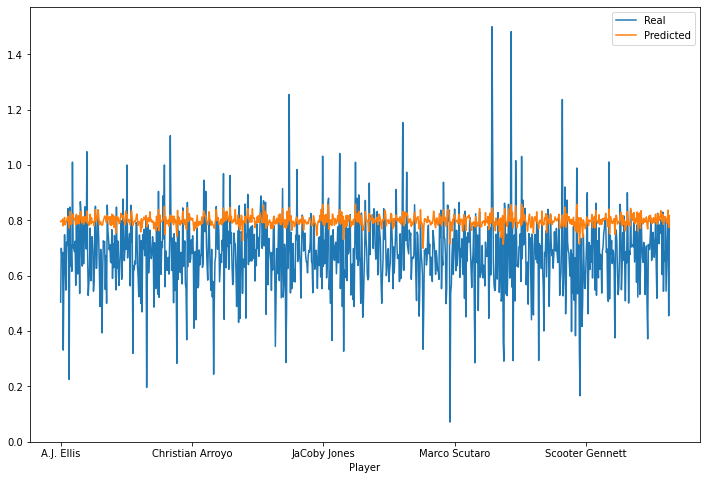

In [17]:
moneyball.plot(figsize=(12,8))